## imports

In [1]:
import sys
import os
import h5py
import mattplotlib

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
import pickle
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils
Running on Computer: [beast]
Save_dir = ./Monocular/


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


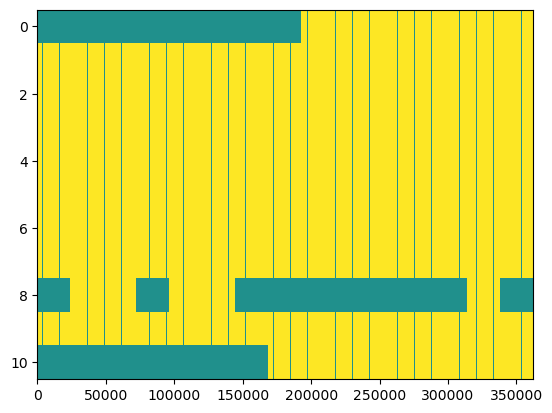

In [2]:
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

## NIM

In [3]:
# jump right to shared models
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

Network 0:
  Layer 0:
      weight: torch.Size([360, 8])
  Layer 1:
      weight: torch.Size([8, 11])
      bias: torch.Size([11])


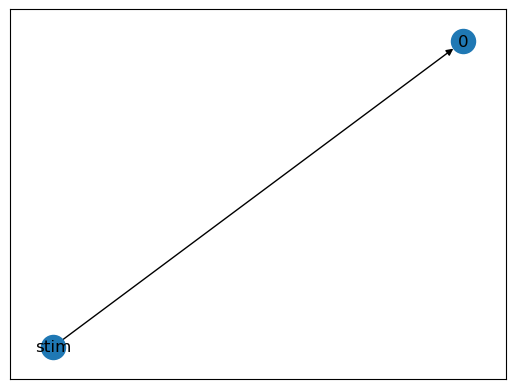

In [4]:
## Shared NIM
num_subs = 8
XTreg0 = 0.1
L1reg0 = 0.0001
Greg = 0.001

# subunit layer
sub_par = NDNLayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, norm_type=1,
    NLtype='relu', bias=False, initialize_center = True)
sub_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'localx':0.001, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC, 
    norm_type=0,
    NLtype='softplus', 
    bias=True, 
    initialize_center = True)

nim_all = NDN.NDN( layer_list=[sub_par, readout_par] )

m.draw_model(nim_all)

nim_all.list_parameters()

In [47]:
# nim_all.fit(data, **adam_pars, verbose=2)
# LLs1 = nim_all.eval_models(data[data.val_inds], null_adjusted=True)
# print(LLs1)
# print(np.mean(LLs1))
# 

# with open('nim1.pickle', 'wb') as f:
#    pickle.dump(nim_all, f)
with open('nim1.pickle', 'rb') as f:
    nim_all = pickle.load(f)

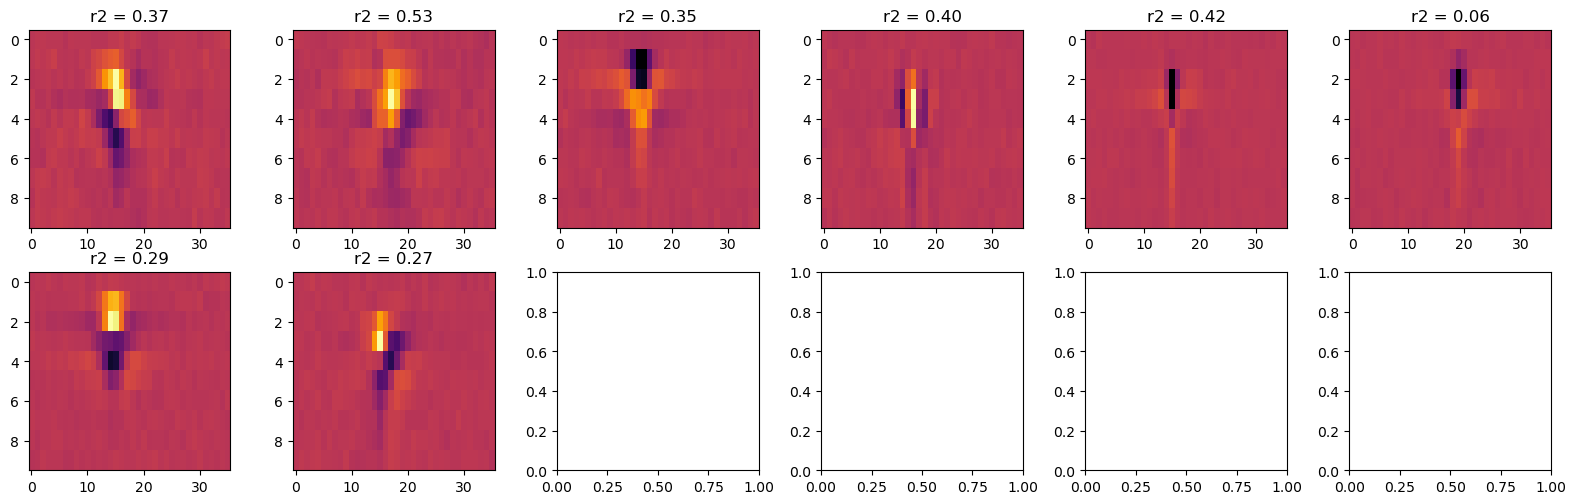

In [6]:
glm_r2s = ['%.2f'%r2 for r2 in met.r2(data, nim_all)]

# plot GLM filters
ss(2, 6)
for c in range(8):
    plt.subplot(2, 6, c+1)
    imagesc(nim_all.networks[0].layers[0].get_weights()[:,:,c], cmap='inferno')
    plt.title('r2 = ' + glm_r2s[c])
plt.show()

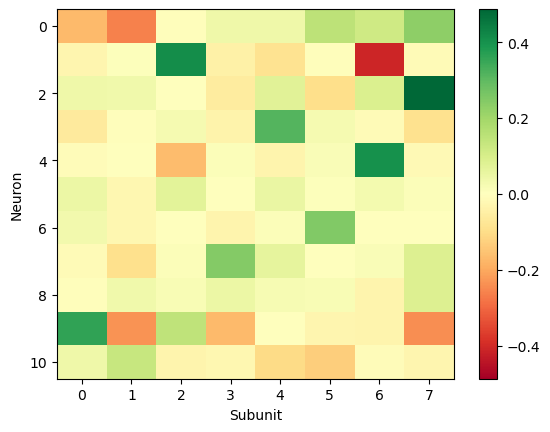

In [7]:
# Readout layer
wR = nim_all.get_weights(layer_target=1)
imagesc(wR, cmap='RdYlGn')
plt.xlabel('Subunit')
plt.ylabel('Neuron')
plt.colorbar()
plt.show()

### plot the filter as the weighted sum of one of the neurons 

In [8]:
hidden = nim_all.networks[0].layers[0].get_weights()
output = nim_all.get_weights(layer_target=1)
hidden.shape, output.shape

((36, 10, 8), (8, 11))

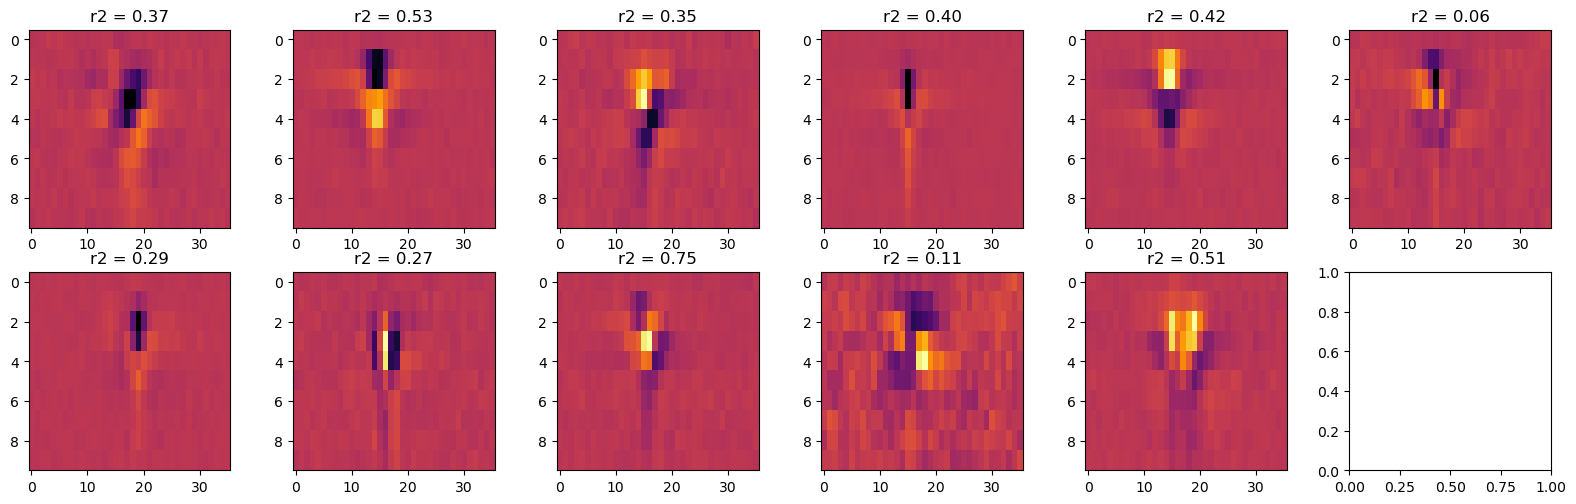

In [9]:
nim_r2s = ['%.2f'%r2 for r2 in met.r2(data, nim_all)]

# plot cell weighted filters
ss(2, 6)
for c in range(11):
    plt.subplot(2, 6, c+1)
    rfield = np.sum((hidden.reshape(360,8) * output[:,c]).reshape(36,10,8), axis=2).T
    imin = -np.max(abs(rfield))
    imax = np.max(abs(rfield))
    plt.imshow(rfield, cmap='inferno', aspect='auto', vmin=imin, vmax=imax)
    plt.title('r2 = ' + nim_r2s[c])
plt.show()

### all data on GPU

In [10]:
## If there is enough memory on the device, can put the whole dataloader on the GPU
#del train_ds , val_ds
torch.cuda.empty_cache()

data.set_cells()
train_ds = GenericDataset(data[data.train_inds], device=device)
val_ds = GenericDataset(data[data.val_inds], device=device)

  Reset cells_out to full dataset (11 cells).


In [23]:
## About 2x speedup
#nim_all = NDN.NDN( layer_list=[sub_par, readout_par])
#nim_all.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
#LLs1 = nim_all.eval_models(val_ds, null_adjusted=True)
#print(LLs1, np.mean(LLs1))

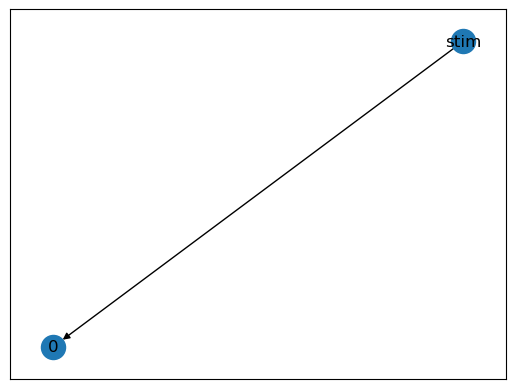

In [24]:
m.draw_model(nim_all)

In [25]:
nim_all.networks[0].layers[0](data.stim).shape

torch.Size([362504, 8])

<Figure size 640x480 with 0 Axes>

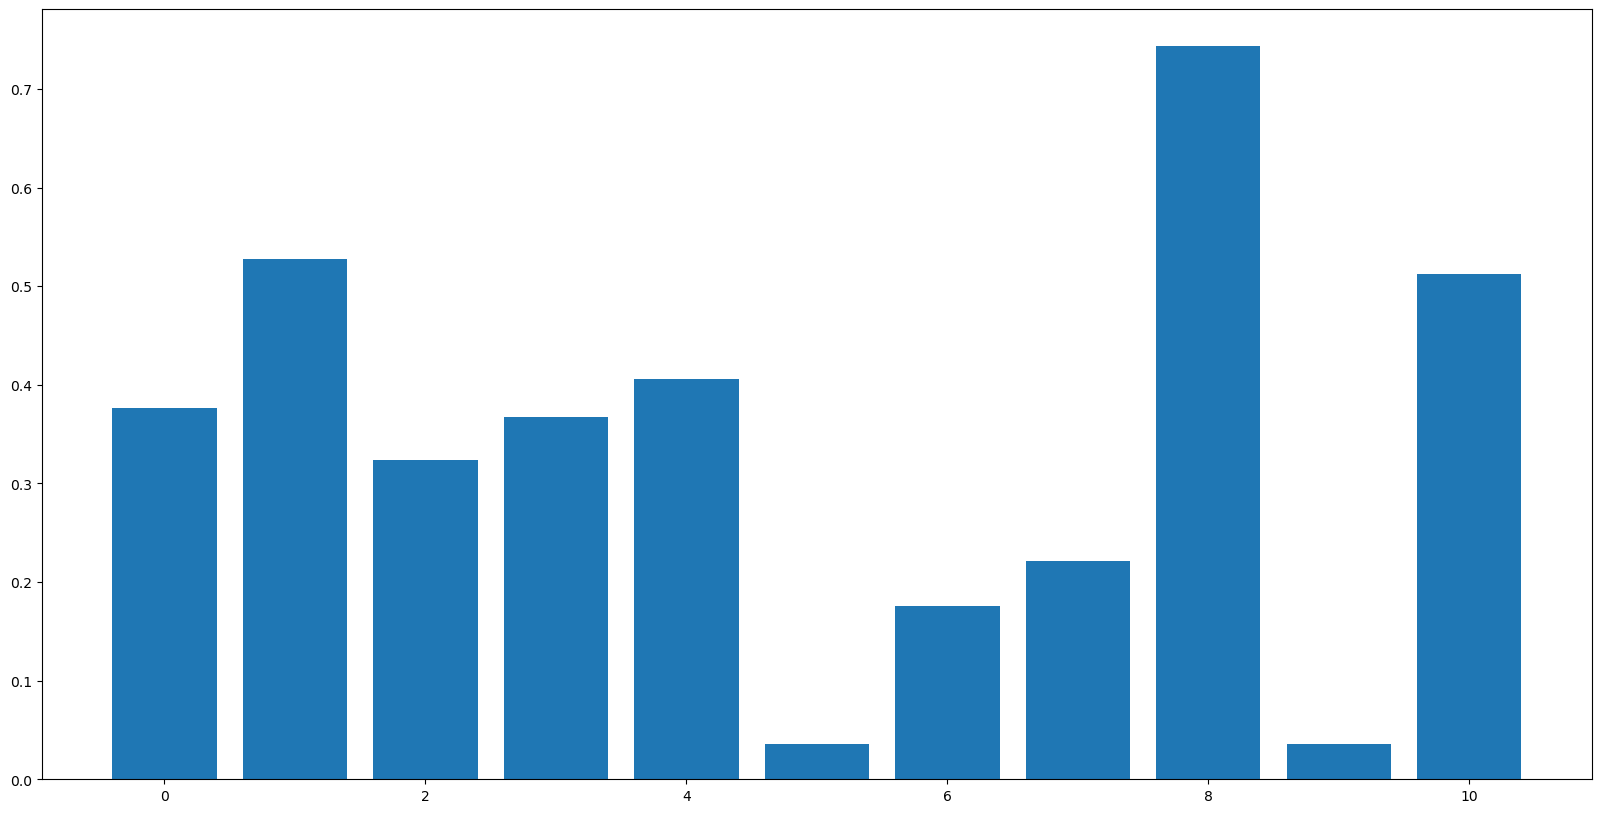

In [26]:
# R2
m.fig()
plt.bar(range(11), met.r2(data, nim_all))
plt.show()

## plot using cool plotting stuff

In [49]:
from IPython.display import display, Javascript, HTML
import json

def draw_grids(data, edges, width, layer_heights, layer_dims, padding, layer_padding):
    display(Javascript("""
        (function(element){
            require(['grids'], function(grids) {
                grids(element.get(0), %s, %s, %d, %s, %s, %d, %d);
            });
        })(element);
    """ % (json.dumps(data), edges, width, layer_heights, layer_dims, padding, layer_padding)))

In [50]:
arr0 = [np.random.random((3,3)).tolist() for _ in range(6)]
arr1 = [np.random.random((3,3)).tolist() for _ in range(12)]
layers = [arr0, arr1]
edges = {
    "c1": [1,2,3,10]
}

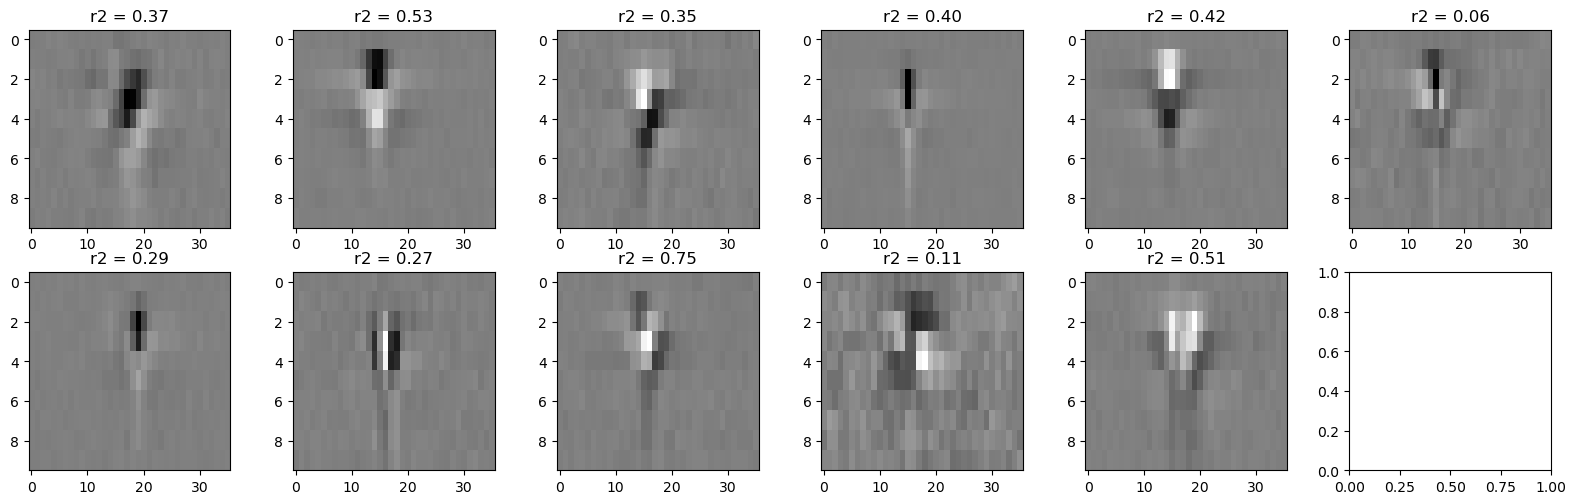

In [51]:
# plot cell weighted filters
hidden = nim_all.networks[0].layers[0].get_weights()
output = nim_all.networks[0].layers[1].get_weights()

ss(2, 6)
for c in range(11):
    plt.subplot(2, 6, c+1)
    rfield = np.sum((hidden.reshape(360,8) * output[:,c]).reshape(36,10,8), axis=2).T
    imin = -np.max(abs(rfield))
    imax = np.max(abs(rfield))
    plt.imshow(rfield, cmap='gray', aspect='auto', vmin=imin, vmax=imax)
    plt.title('r2 = ' + nim_r2s[c])
plt.show()


In [52]:
# plot cell weighted filters
hidden = nim_all.networks[0].layers[0].get_weights()
output = nim_all.networks[0].layers[1].get_weights()

rfields = []
for c in range(11):
    rfield = np.sum((hidden.reshape(360,8) * output[:,c]).reshape(36,10,8), axis=2).T
    imin = -np.max(abs(rfield))
    imax = np.max(abs(rfield))
    rfields.append(rfield.tolist())

len(rfields), np.array(rfields).shape

(11, (11, 10, 36))

In [53]:
hidden.shape, output.shape

((36, 10, 8), (8, 11))

In [54]:
# plot it

In [55]:
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="grids.js"))
display(HTML(filename="grids.css.html"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
# use exact dimensions to make sure it does work when not having floating point issues
draw_grids([rfields[:8]],
           {"c1": [1,2,3,10]},
           height=200, width=288,
           layer_dims={0:{'rows':2, 'cols':4}},
           padding=0,
           layer_padding=0)

TypeError: draw_grids() got an unexpected keyword argument 'height'

In [ ]:
# add layers
hidden.shape, output.shape, np.array(rfields).shape

In [57]:
# get the hidden layer
# move the axes for the hidden layer to make it a list of boxes
print(np.swapaxes(hidden, 0,2).shape)

# get the output layer
# add an axis to the output layer to make the boxes 2d
print(np.expand_dims(output, 1).shape)

# turn them into a list of layers of boxes

(8, 10, 36)
(8, 1, 11)


In [58]:
draw_grids([np.swapaxes(hidden, 0,2).tolist(), np.expand_dims(output, 1).tolist()],
           {"c1": [1,2,3,10]},
           height=400, width=600,
           layer_dims={0:{'rows':2, 'cols':4}, 1:{'rows':1, 'cols':8}},
           padding=10,
           layer_padding=20)

TypeError: draw_grids() got an unexpected keyword argument 'height'

In [59]:
# add edges
hidden = nim_all.networks[0].layers[0].get_weights()
output = nim_all.networks[0].layers[1].get_weights()
print(hidden.shape, output.shape)

(36, 10, 8) (8, 11)


In [60]:
# hidden layer reshaped to be a list of 8 boxes
# (36, 10, 8) --> (8, 10, 36)
hidden_boxes = np.swapaxes(hidden, 0,2)
# means of the weights of each neuron
# (8, 11) --> (1, 11) --> (1, 1, 11)
output_sums = np.expand_dims(np.expand_dims(np.sum(output, axis=0), 1),1)

hidden_boxes.shape, output_means.shape

NameError: name 'output_means' is not defined

In [61]:
# create weights
starting_c = 2880 # terrible hack
weights = {}
# create the edge dictionary per neuron
for c in range(output.shape[1]): # for each neuron
    weights[c+starting_c] = {}
    i = 0 # start the id
    # normalize output
    posnorm = np.where(output[:,c]>=0, output[:,c], 0) / np.max(output[:,c][output[:,c]>=0])
    negnorm = np.where(output[:,c]<0, output[:,c], 0) / np.abs(np.min(output[:,c][output[:,c]<0]))
    output_normalized = posnorm + negnorm
    print(np.min(output_normalized), np.max(output_normalized))
    for b, w in enumerate(output_normalized): # for each box & its weight
        for row in range(hidden_boxes[b,:,:].shape[0]): # for each row in the box
            for row in range(hidden_boxes[b,:,:].shape[1]): # for each col in that row
                weights[c+starting_c][i] = w
                i += 1
                
print(weights.keys())
print(np.sum(hidden_boxes), np.sum(output_means))

-1.0 1.0
-1.0 1.0
-1.0 1.0
-1.0 1.0
-1.0 1.0
-1.0 1.0
-1.0 1.0
-1.0 1.0
-1.0 1.0
-1.0 1.0
-1.0 1.0
dict_keys([2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890])


NameError: name 'output_means' is not defined

In [62]:
# normalize the data we are giving the plot
# preserve dimensionality
# https://stackoverflow.com/questions/29046162/numpy-array-loss-of-dimension-when-masking
posnorm = np.where(hidden_boxes>=0, hidden_boxes, 0) / np.max(hidden_boxes[hidden_boxes>=0])
negnorm = np.where(hidden_boxes<0, hidden_boxes, 0) / np.abs(np.min(hidden_boxes[hidden_boxes<0]))

hidden_boxes_normalized = posnorm + negnorm
print(hidden_boxes_normalized.shape)

print(np.min(hidden_boxes_normalized), np.max(hidden_boxes_normalized))

(8, 10, 36)
-1.0 1.0


In [63]:
# define nice functions to transform the network data to the view data format
# move this to mattplotlib.py once it works
def toview(layers):
    # adjacent layers need to be swapped, I think?
    
    # hidden layer reshaped to be a list of 8 boxes
    # (36, 10, 8) --> (8, 10, 36)
    hidden_boxes = np.swapaxes(hidden, 0,2)
    # means of the weights of each neuron
    # (8, 11) --> (11) --> (1, 1, 11)
    output_sums = np.expand_dims(np.expand_dims(np.sum(output, axis=0), 1),1)
    
    # create weights
    starting_c = 2880 # terrible hack
    weights = {}
    # create the edge dictionary per neuron
    for c in range(output.shape[1]): # for each neuron
        weights[c+starting_c] = {}
        i = 0 # start the id
        # normalize output
        posnorm = np.where(output[:,c]>=0, output[:,c], 0) / np.max(output[:,c][output[:,c]>=0])
        negnorm = np.where(output[:,c]<0, output[:,c], 0) / np.abs(np.min(output[:,c][output[:,c]<0]))
        output_normalized = posnorm + negnorm
        print(np.min(output_normalized), np.max(output_normalized))
        for b, w in enumerate(output_normalized): # for each box & its weight
            for row in range(hidden_boxes[b,:,:].shape[0]): # for each row in the box
                for row in range(hidden_boxes[b,:,:].shape[1]): # for each col in that row
                    weights[c+starting_c][i] = w
                    i += 1
    
    print(weights.keys())
    print(np.sum(hidden_boxes), np.sum(output_sums))
    
    return view_layers, weights
    

In [64]:
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="grids.js"))
display(HTML(filename="grids.css.html"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
# the layers to display
layers = [hidden_boxes_normalized.tolist(), output_sums.tolist()]

draw_grids(layers,
           weights,
           width=600,
           layer_heights={0:200, 1:50},
           layer_dims={0:{'rows':2, 'cols':4}, 1:{'rows':1, 'cols':11}},
           padding=5,
           layer_padding=10)

<IPython.core.display.Javascript object>

/tmp/ipykernel_97336/3111585936.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 4, i+1)


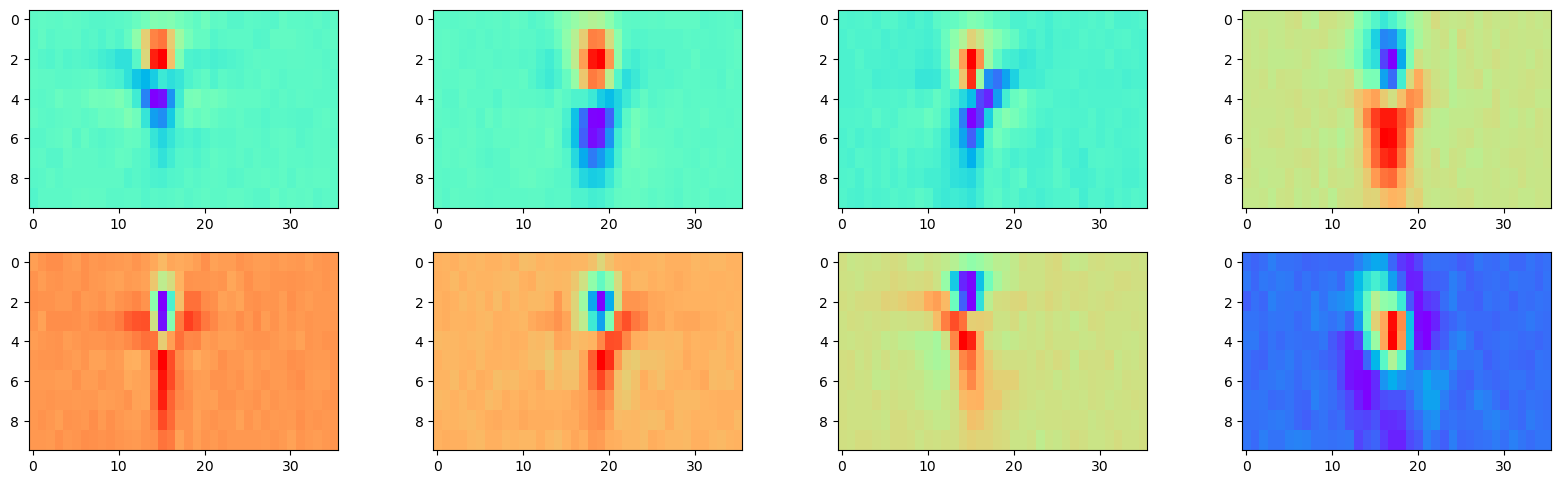

In [45]:
ss(2, 6)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(hidden_boxes[i,:,:], cmap='rainbow', aspect='auto')
plt.show()

## test stuff

In [ ]:
arr0 = [np.random.random((3,3)).tolist() for _ in range(6)]
arr2 = [np.random.random((3,3)).tolist() for _ in range(12)]
arr1 = [[[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]],
        [[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]],
        [[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]],
        [[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]],
        [[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]],
        [[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]]]

layers = [arr1, arr0, arr2]
edges = {
    "c1": [1,2,3,10]
}
layer_dims = {
    0: {'rows':2, 'cols':3},
    1: {'rows':2, 'cols':3},
    2: {'rows':3, 'cols':4}
}

draw_grids(layers,
           edges,
           height=500, width=400,
           layer_dims=layer_dims,
           padding=10,
           layer_padding=30)

In [ ]:
# [X] draw a grid of rectangles
# [X] make the rectangles selectable with the mouse
# [X] draw the grid based on what is passed in by the user
# [X] draw list of grids
# [X] pass in two sets of arrs and draw them one on top of the other
# [X] connect the selecting change in appearance of grids
# [X] highlight the corresponding weights when mousing over
# [X] make the rows and cols per layer, not the same for all layers
# [X] make it maintain aspect ratio when drawing different dimensions
#       NOTE: this is weird b/c a lot of the width/height incrementing is hardcoded 
#             and space is divided up into equal space partitions
#             Allowing different spaced partitions will likely require
#             refactoring the structure of each layer and the grids.
#             Not a bad idea, but possibly more work. Will have to think on it...
#       NOTE: this might take more work than I had hoped... but it works with some width/height combos
#       NOTE: the issue was dividing and also having non-integer zoom enabled in Chrome...
# [X] fix the intensity scaling

# TODO: convert the NDNT network to the layers and edges format needed for this API
# TODO: draw a fun curvy arrow between the two networks